In [2]:
import os
from datetime import datetime

import json
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

In [3]:
# Select latest data file
folder = '../data/'
files = [file for file in os.listdir(folder) if not file.startswith('.~lock')]
most_recent_data_file = max(files, key=lambda x: datetime.strptime(x.split('-')[0] + x.split('-')[1] + x.split('-')[2] + " " + x.split('-')[3] + ":" + x.split('-')[4] + ":" + x.split('-')[5], '%Y%m%d %H:%M:%S'))
data_file = folder + most_recent_data_file
print("Data file: {}".format(data_file))

Data file: ../data/2024-09-27-09-14-19-data-up-to-859999-m-208-k-4032-completed.json


In [4]:
# Load data into DataFrame
with open(data_file, 'r') as data_file:
    data = json.load(data_file)
df = pd.DataFrame(data)

In [5]:
# Is df[COLUMN] monotonically increasing?
print("Is df[COLUMN] monotonically increasing?\n")
print(f"df['timestamp']     {str(df['timestamp'].is_monotonic_increasing):5}. Should be False")
print(f"df['proof_score']   {str(df['proof_score'].is_monotonic_increasing):5}. Should be False.")
print(f"df['proof_size']    {str(df['proof_size'].is_monotonic_increasing):5}. Should be False.")
print(f"df['target']        {str(df['target'].is_monotonic_decreasing):5}. Should be False.")

Is df[COLUMN] monotonically increasing?

df['timestamp']     False. Should be False
df['proof_score']   False. Should be False.
df['proof_size']    False. Should be False.
df['target']        False. Should be False.


In [6]:
# Add block height (index) as column
df["height"] = df.index + 1

In [7]:
# Create datetime objects column from timestamps column
df['timestamp_dt'] = pd.to_datetime(df['timestamp'], unit='s')
df

,target,proof_size,proof_score,timestamp,height,timestamp_dt
0,2695953529101130949315647634472399133601089873...,1,1,1231006505,1,2009-01-03 18:15:05
1,2695953529101130949315647634472399133601089873...,2,2,1231469665,2,2009-01-09 02:54:25
2,2695953529101130949315647634472399133601089873...,3,3,1231469744,3,2009-01-09 02:55:44
3,2695953529101130949315647634472399133601089873...,4,4,1231470173,4,2009-01-09 03:02:53
4,2695953529101130949315647634472399133601089873...,5,5,1231470988,5,2009-01-09 03:16:28
...,...,...,...,...,...,...
859995,3013192540701495855489719056459487864454832683...,6814,530981487752033941,1725536078,859996,2024-09-05 11:34:38
859996,3013192540701495855489719056459487864454832683...,6815,531070959416810911,1725536890,859997,2024-09-05 11:48:10
859997,3013192540701495855489719056459487864454832683...,6813,530897050348136819,1725538120,859998,2024-09-05 12:08:40
859998,3013192540701495855489719056459487864454832683...,6814,530986522012913789,1725538608,859999,2024-09-05 12:16:48


In [8]:
df.dtypes

target                  object
proof_size               int64
proof_score              int64
timestamp                int64
height                   int64
timestamp_dt    datetime64[ns]
dtype: object

In [9]:
# DataFrame description
df.describe()

,proof_size,proof_score,timestamp,height,timestamp_dt
count,860000.000000,8.600000e+05,8.600000e+05,860000.000000,860000
mean,6546.487003,6.861889e+16,1.477292e+09,430000.500000,2016-10-24 06:45:46.708926208
min,1.000000,1.000000e+00,1.231007e+09,1.000000,2009-01-03 18:15:05
25%,6415.000000,1.845421e+10,1.357233e+09,215000.750000,2013-01-03 17:14:28.500000
50%,6652.000000,1.259508e+15,1.473982e+09,430000.500000,2016-09-15 23:30:10.500000
75%,6790.000000,9.755988e+16,1.598190e+09,645000.250000,2020-08-23 13:42:45.750000128
max,7117.000000,5.320903e+17,1.725539e+09,860000.000000,2024-09-05 12:17:12
std,457.595672,1.206344e+17,1.402039e+08,248260.760089,NaN


/tmp/ipykernel_53347/65161511.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


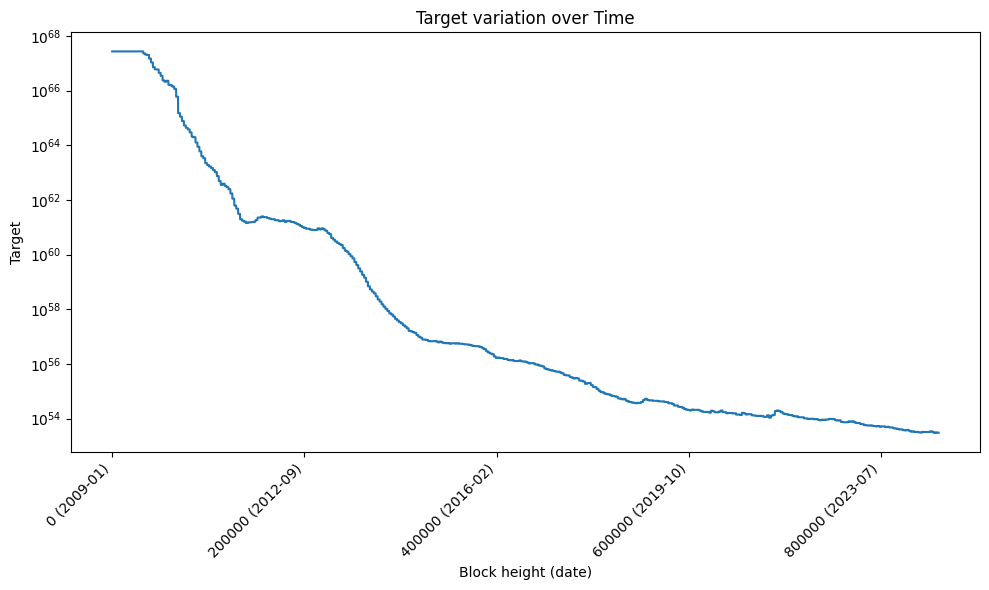

In [10]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['target'], estimator=None, sort=False)

plt.title('Target variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Target')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

plt.grid(False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_53347/3834408529.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


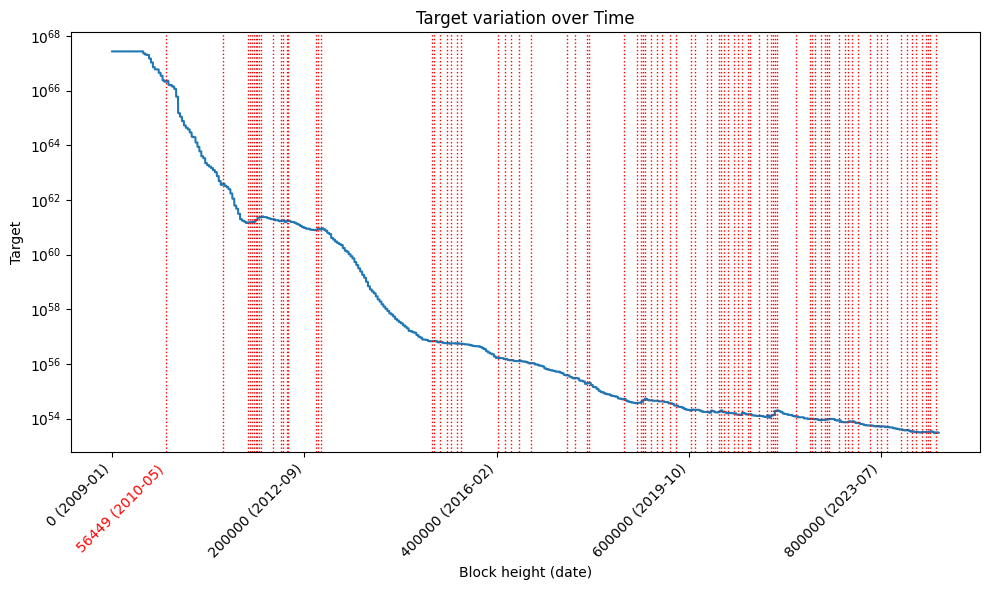

In [11]:
# Plot target over time with target increases
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['target'], estimator=None, sort=False)

plt.title('Target variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Target')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

# Add vertical red lines when target increases
prev_target = None
first_red_line_label = False
for i, target in enumerate(df['target']):
    if prev_target is not None and target > prev_target:
        # print(df.iloc[i]['height']) # print block heights of red lines
        plt.axvline(x=df.iloc[i]['height'], color='red', linestyle=':', linewidth=1)
        if not first_red_line_label:
            plt.text(df.iloc[i]['height'], -0.025, f"{df.iloc[i]['height']} ({df.iloc[i]['timestamp_dt'].strftime('%Y-%m')})", transform=plt.gca().get_xaxis_transform(), ha='right', va='top', rotation=45, color='red')
            first_red_line_label = True
    prev_target = target

plt.grid(False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_53347/3237839063.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


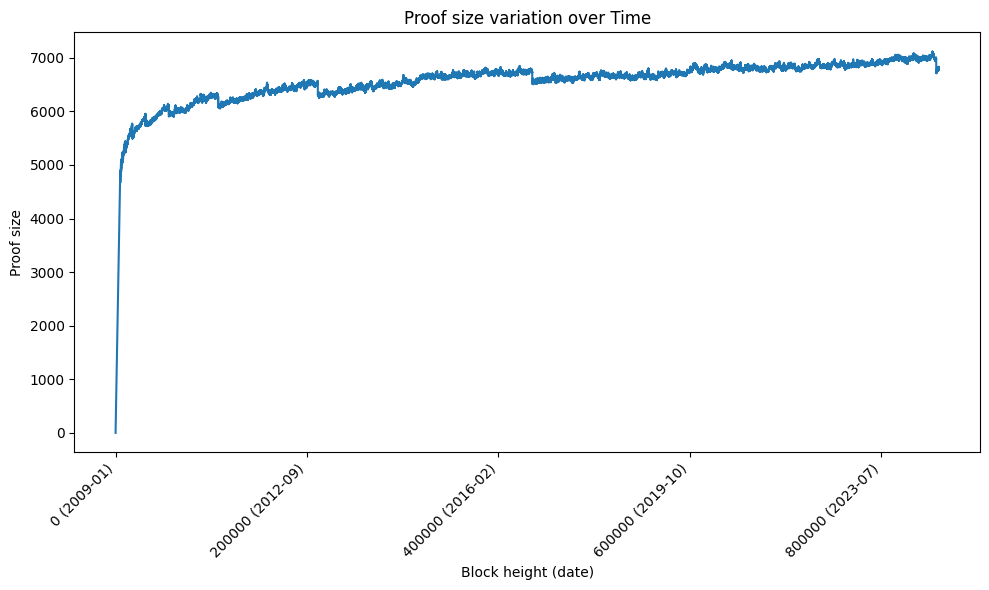

In [12]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_size'], estimator=None, sort=False)

plt.title('Proof size variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Proof size')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

plt.grid(False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_53347/2242784311.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


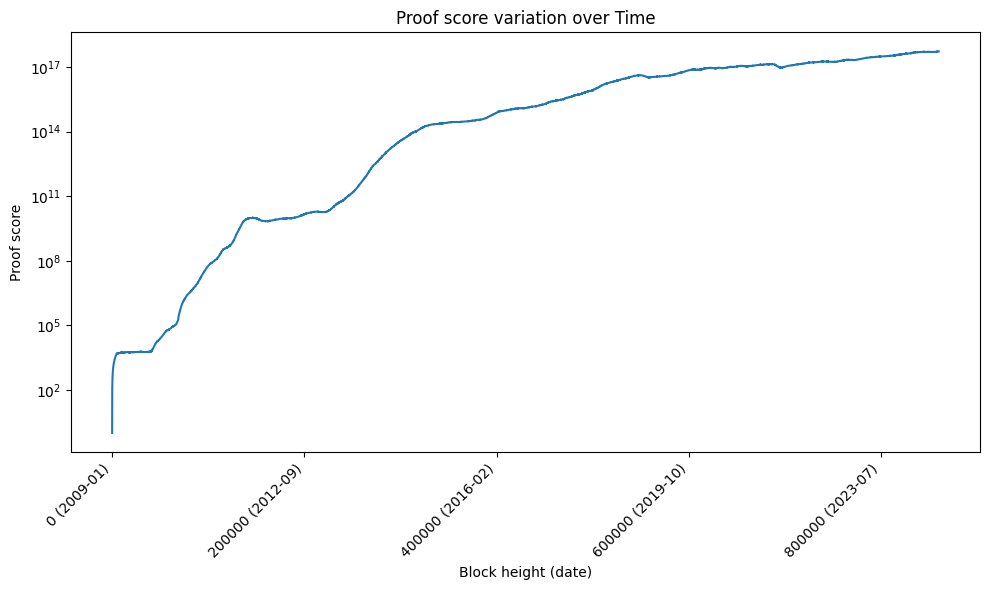

In [13]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_score'], estimator=None, sort=False)

plt.title('Proof score variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Proof score')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

# Change y-axis to logscale
plt.gca().yaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
plt.gca().yaxis.offsetText.set_visible(False)  # Hide the offset text
plt.yscale('log')  # Set y-axis to log scale

plt.grid(False)
plt.tight_layout()
plt.show()

/tmp/ipykernel_53347/2061534677.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right


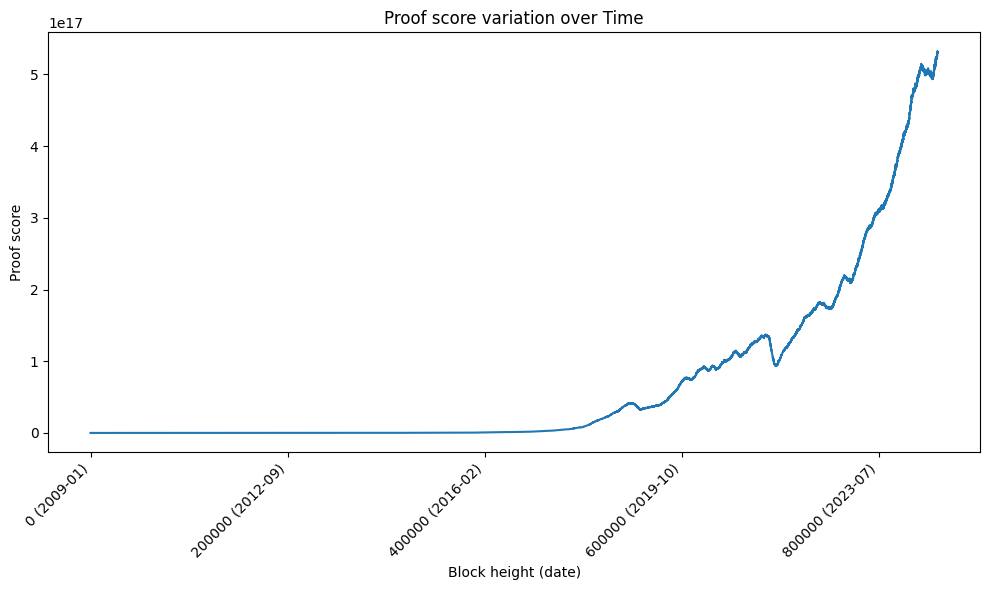

In [14]:
# Plot target over time
plt.figure(figsize=(10, 6))
sns.lineplot(x=df['height'], y=df['proof_score'], estimator=None, sort=False)

plt.title('Proof score variation over Time')
plt.xlabel('Block height (date)')
plt.ylabel('Proof score')

# Change x-axis labels to include date
orig_x_labels = plt.gca().get_xticklabels() # Get the existing tick labels
orig_x_labels.pop(0) # Pop first element which is irrelevant (-100000)
heights = [int(label.get_text().split()[0]) for label in orig_x_labels] # Retrieve the corresponding heights for the tick labels
heights.insert(0, 0) # Add relevant popped label back into heights (0)
corresponding_dates = [] # Find the corresponding dates for the heights
for height in heights:
    idx = df['height'].sub(height).abs().idxmin()
    corresponding_dates.append(df.loc[idx, 'timestamp_dt'])
new_labels = [f"{height} ({date.strftime('%Y-%m')})" for height, date in zip(heights, corresponding_dates)] # Combine the heights and corresponding dates into new tick labels
plt.gca().set_xticklabels(new_labels, rotation=45, ha='right')  # Set the new tick labels and rotate the labels by 45 degrees and align to the right

plt.grid(False)
plt.tight_layout()
plt.show()